
This page uses data from the OpenPowerlifting project, https://www.openpowerlifting.org.
You may download a copy of the data at https://gitlab.com/openpowerlifting/opl-data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as st
from glob import glob
from urllib.request import urlretrieve

After importing the libraries, we need to see what we're working with for data. We'll start with the meets.csv file, and check the first few rows of data for general structure, the info for the dataset to see where there are missing values, and describe to see if there are any immediate outliers. 

In [2]:

meets_df = pd.read_csv("meets.csv")
competitors_df = pd.read_csv("openpowerlifting.csv")
print(meets_df.shape)
print(meets_df.head())
print(meets_df.info(verbose=True))

(8482, 8)
   MeetID        MeetPath Federation        Date MeetCountry MeetState  \
0       0  365strong/1601  365Strong  2016-10-29         USA        NC   
1       1  365strong/1602  365Strong  2016-11-19         USA        MO   
2       2  365strong/1603  365Strong  2016-07-09         USA        NC   
3       3  365strong/1604  365Strong  2016-06-11         USA        SC   
4       4  365strong/1605  365Strong  2016-04-10         USA        SC   

    MeetTown                                           MeetName  
0  Charlotte  2016 Junior & Senior National Powerlifting Cha...  
1      Ozark                  Thanksgiving Powerlifting Classic  
2  Charlotte                             Charlotte Europa Games  
3  Rock Hill                   Carolina Cup Push Pull Challenge  
4  Rock Hill                              Eastern USA Challenge  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8482 entries, 0 to 8481
Data columns (total 8 columns):
MeetID         8482 non-null int64
MeetPath

In [3]:
meets_df.describe()

,MeetID
count,8482.000000
mean,4240.500000
std,2448.686825
min,0.000000
25%,2120.250000
50%,4240.500000
75%,6360.750000
max,8481.000000


Nothing seems too obscure from this, only missing values seems to be in MeetState and MeetTown. This won't be a problem, as it's not essential information, and since not all meets are in the U.S., there wouldn't always be a State to be used. 

Looking farther, we see within the meets_df, there is a 'Date' column that should be converted to a datetime object, to use to explore when meets take place. We'll also take a look at what countries meets are taking place in. We'll also create new columns specifically for the year and month to see if there are trends in when meets take place. 

In [4]:
meets_df['Date'] = pd.to_datetime(meets_df['Date'])
meets_df['Month'] = meets_df['Date'].apply(lambda x: x.month)
meets_df['Year'] = meets_df['Date'].apply(lambda x: x.year)
meets_df.head()

,MeetID,MeetPath,Federation,Date,MeetCountry,MeetState,MeetTown,MeetName,Month,Year
0,0,365strong/1601,365Strong,2016-10-29,USA,NC,Charlotte,2016 Junior & Senior National Powerlifting Cha...,10,2016
1,1,365strong/1602,365Strong,2016-11-19,USA,MO,Ozark,Thanksgiving Powerlifting Classic,11,2016
2,2,365strong/1603,365Strong,2016-07-09,USA,NC,Charlotte,Charlotte Europa Games,7,2016
3,3,365strong/1604,365Strong,2016-06-11,USA,SC,Rock Hill,Carolina Cup Push Pull Challenge,6,2016
4,4,365strong/1605,365Strong,2016-04-10,USA,SC,Rock Hill,Eastern USA Challenge,4,2016


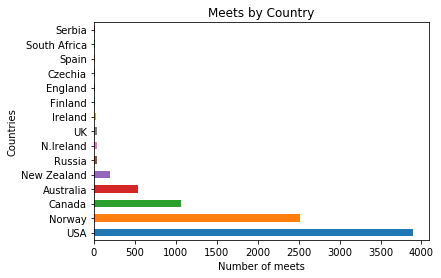

In [5]:
meets_df.MeetCountry.value_counts()[:15].plot(kind='barh')
type(meets_df.MeetCountry.value_counts())
plt.title('Meets by Country')
plt.xlabel('Number of meets')
plt.ylabel('Countries')
plt.show()

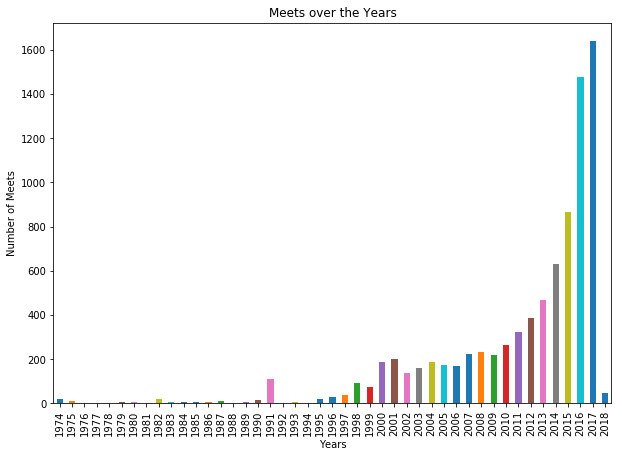

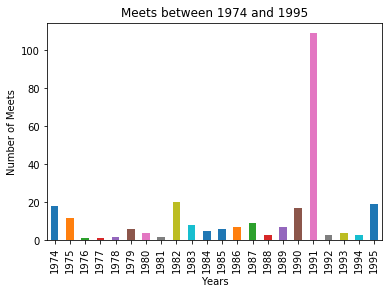

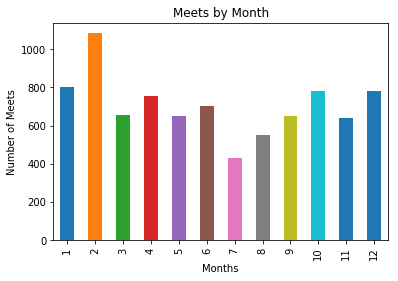

In [6]:
plt.figure(figsize=(10,7))
meets_df.Year.value_counts(sort=False).sort_index().plot(kind='bar')
plt.title('Meets over the Years')
plt.xlabel('Years')
plt.ylabel('Number of Meets')
plt.show()
meets_df.Year[(meets_df.Year < 1996) &(meets_df.Year >= 1974)].value_counts().sort_index().plot(kind='bar')
plt.title('Meets between 1974 and 1995')
plt.xlabel('Years')
plt.ylabel('Number of Meets')
plt.show()
meets_df.Month.value_counts().sort_index().plot(kind='bar')
plt.title('Meets by Month')
plt.xlabel('Months')
plt.ylabel('Number of Meets')
plt.show()

When plotting the total meets by year, from the beginning of the recorded dataset to the most recent (early 2018), it was noticed that there was a large jump in 1991, unsure why this is, we'll explore the ~100 meets for that year to see if there is anything that looks incorrect with the data. Otherwise, it looks about as expected, with more competitions forming over the years as the popularity of the sport grew, as well as the overall population.

As for when meets take place, February seems to be the most popular month. 

Now we're going to look at the competitors dataframe to see what sort of data it holds. We'll start again by looking at the first few rows, the info to look for missing values, and then describe to see if there are any obvious outliers. 

In [7]:
print(competitors_df.shape)
competitors_df.head()

(386414, 17)


,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,Squat4Kg,BestSquatKg,Bench4Kg,BestBenchKg,Deadlift4Kg,BestDeadliftKg,TotalKg,Place,Wilks
0,0,Angie Belk Terry,F,Wraps,47.0,Mst 45-49,59.60,60,NaN,47.63,NaN,20.41,NaN,70.31,138.35,1,155.05
1,0,Dawn Bogart,F,Single-ply,42.0,Mst 40-44,58.51,60,NaN,142.88,NaN,95.25,NaN,163.29,401.42,1,456.38
2,0,Dawn Bogart,F,Single-ply,42.0,Open Senior,58.51,60,NaN,142.88,NaN,95.25,NaN,163.29,401.42,1,456.38
3,0,Dawn Bogart,F,Raw,42.0,Open Senior,58.51,60,NaN,NaN,NaN,95.25,NaN,NaN,95.25,1,108.29
4,0,Destiny Dula,F,Raw,18.0,Teen 18-19,63.68,67.5,NaN,NaN,NaN,31.75,NaN,90.72,122.47,1,130.47


In [8]:
print(competitors_df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386414 entries, 0 to 386413
Data columns (total 17 columns):
MeetID            386414 non-null int64
Name              386414 non-null object
Sex               386414 non-null object
Equipment         386414 non-null object
Age               147147 non-null float64
Division          370571 non-null object
BodyweightKg      384012 non-null float64
WeightClassKg     382602 non-null object
Squat4Kg          1243 non-null float64
BestSquatKg       298071 non-null float64
Bench4Kg          1962 non-null float64
BestBenchKg       356364 non-null float64
Deadlift4Kg       2800 non-null float64
BestDeadliftKg    317847 non-null float64
TotalKg           363237 non-null float64
Place             385322 non-null object
Wilks             362194 non-null float64
dtypes: float64(10), int64(1), object(6)
memory usage: 50.1+ MB
None


In [9]:
competitors_df.describe()

,MeetID,Age,BodyweightKg,Squat4Kg,BestSquatKg,Bench4Kg,BestBenchKg,Deadlift4Kg,BestDeadliftKg,TotalKg,Wilks
count,386414.000000,147147.000000,384012.000000,1243.000000,298071.000000,1962.000000,356364.000000,2800.000000,317847.000000,363237.000000,362194.000000
mean,5143.015804,31.668237,86.934912,107.036404,176.569941,45.722905,118.347509,113.597193,195.040633,424.000249,301.080601
std,2552.099838,12.900342,23.140843,166.976620,69.222785,151.668221,54.848850,170.201657,61.580675,196.355147,116.360396
min,0.000000,5.000000,15.880000,-440.500000,-477.500000,-360.000000,-522.500000,-461.000000,-410.000000,11.000000,13.730000
25%,2979.000000,22.000000,70.300000,87.500000,127.500000,-90.000000,79.380000,110.000000,147.500000,272.160000,237.380000
50%,5960.000000,28.000000,83.200000,145.000000,174.630000,90.250000,115.000000,157.500000,195.000000,424.110000,319.660000
75%,7175.000000,39.000000,100.000000,212.500000,217.720000,167.500000,150.000000,219.990000,238.140000,565.000000,379.290000
max,8481.000000,95.000000,242.400000,450.000000,573.790000,378.750000,488.500000,418.000000,460.400000,1365.310000,779.380000


Right off there are a few things that look off with the data. For all the lift values, there are minimums that are negative. These were lifts that didn't qualify. For this data, we'll inspecty how many lifts were report as negative and determine how they should be handled. If there are a small number, we'll drop those records that contain negative lift values.

Something interesting in the Age column, is that the youngest lifter that has competed is 5, and the oldest, 95. 

We also see that the Bench4Kg, Deadlift4Kg, and Squat4Kg columns are missing a large amount of data. For these, we'll drop the columns entirely. 

Another thing that will be considered, is what columns can be changed to categories. 

It seems the best way to uniquely identify a row is through MeetID and Name; these will be used for joint indexing. 

In [10]:
comps_slim = competitors_df.drop(['Squat4Kg', 'Bench4Kg', 'Deadlift4Kg'], axis=1)
comps_slim.columns


Index(['MeetID', 'Name', 'Sex', 'Equipment', 'Age', 'Division', 'BodyweightKg',
       'WeightClassKg', 'BestSquatKg', 'BestBenchKg', 'BestDeadliftKg',
       'TotalKg', 'Place', 'Wilks'],
      dtype='object')

In [11]:
comps_slim.Equipment = comps_slim.Equipment.astype('category')
comps_slim.Sex = comps_slim.Sex.astype('category')
print(comps_slim.Sex.unique()) 
print(comps_slim.Equipment.unique())

[F, M]
Categories (2, object): [F, M]
[Wraps, Single-ply, Raw, Multi-ply, Straps]
Categories (5, object): [Wraps, Single-ply, Raw, Multi-ply, Straps]


In [12]:
comps_slim.head()

,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks
0,0,Angie Belk Terry,F,Wraps,47.0,Mst 45-49,59.60,60,47.63,20.41,70.31,138.35,1,155.05
1,0,Dawn Bogart,F,Single-ply,42.0,Mst 40-44,58.51,60,142.88,95.25,163.29,401.42,1,456.38
2,0,Dawn Bogart,F,Single-ply,42.0,Open Senior,58.51,60,142.88,95.25,163.29,401.42,1,456.38
3,0,Dawn Bogart,F,Raw,42.0,Open Senior,58.51,60,NaN,95.25,NaN,95.25,1,108.29
4,0,Destiny Dula,F,Raw,18.0,Teen 18-19,63.68,67.5,NaN,31.75,90.72,122.47,1,130.47


In [13]:
# Determine how frequent negative values occur by including any rows with at least 1 negative lift, 
# then dividing that number of rows by the total number in the dataframe.
percent_neg = len(comps_slim[(comps_slim['BestSquatKg'] < 0) | (comps_slim['BestBenchKg'] < 0) | (comps_slim['BestDeadliftKg'] < 0)])/len(comps_slim)
print('Percentage of lifts that are negative: ', str(percent_neg*100))

Percentage of lifts that are negative:  0.7554074127748994


Since it's a small percentage of records that contain a negative value, we'll drop those, and make sure we don't drop null rows as well. 

In [14]:
comps_slim = comps_slim[(comps_slim.BestBenchKg > 0) | comps_slim.BestBenchKg.isnull()]
comps_slim = comps_slim[(comps_slim.BestSquatKg > 0) | comps_slim.BestSquatKg.isnull()]
comps_slim = comps_slim[(comps_slim.BestDeadliftKg > 0) | comps_slim.BestDeadliftKg.isnull()]
comps_slim = comps_slim[(pd.notna(comps_slim.BestBenchKg)) | (pd.notna(comps_slim.BestSquatKg)) | (pd.notna(comps_slim.BestDeadliftKg))]

We want to look farther into missing values, such as those in the BodyweightKg and WeightClasskg. Depending on how many there are, we may just remove all those rows. If there are too many, we'll look at removing only those missing both BodyweightKg and WeightClassKg, Since BodyweightKg within a WeightClassKg is used to determind placement, we will need to remove all rows that have a missing BodyWeight. However, if we are just missing WeightClassKg, we can try to fit it into one of the WeightClassKg based off Sex / BodyweightKg.

In [15]:
comps_slim = comps_slim[(comps_slim.WeightClassKg.notnull())]
#print(comps_slim.info())
females = comps_slim[comps_slim.Sex == 'F']
males = comps_slim[comps_slim.Sex == 'M']
print(females.info())
print(males.info())
print(females.WeightClassKg.unique())
print(males.WeightClassKg.unique())

comps_slim = comps_slim[(comps_slim.BodyweightKg.notnull())]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85382 entries, 0 to 386401
Data columns (total 14 columns):
MeetID            85382 non-null int64
Name              85382 non-null object
Sex               85382 non-null category
Equipment         85382 non-null category
Age               42017 non-null float64
Division          81197 non-null object
BodyweightKg      85157 non-null float64
WeightClassKg     85382 non-null object
BestSquatKg       70066 non-null float64
BestBenchKg       81109 non-null float64
BestDeadliftKg    76579 non-null float64
TotalKg           83650 non-null float64
Place             85150 non-null object
Wilks             83428 non-null float64
dtypes: category(2), float64(7), int64(1), object(4)
memory usage: 8.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 286009 entries, 23 to 386413
Data columns (total 14 columns):
MeetID            286009 non-null int64
Name              286009 non-null object
Sex               286009 non-null category
Equi

After farther examination, it shows that weight classes are not consistent across all Divisions, and trying to reclassify the missing BodyweightKg values would be tough, and not that much more insightful, seeing how few rows were missing it from the whole dataset. 

Missing values for BestSquatKg, BestBenchKg, and BestDeadliftKg are expected, as not everyone is successful at their lifts. Missing Ages may be problematic for viewing age distributions, but we can't disregard all rows that are missing these values becaus we'd lose far too much data. 

I'll display the breakout of ages across all lifters, distinguishing between male / female to see how the age of lifters corresponds to Sex, if at all. 

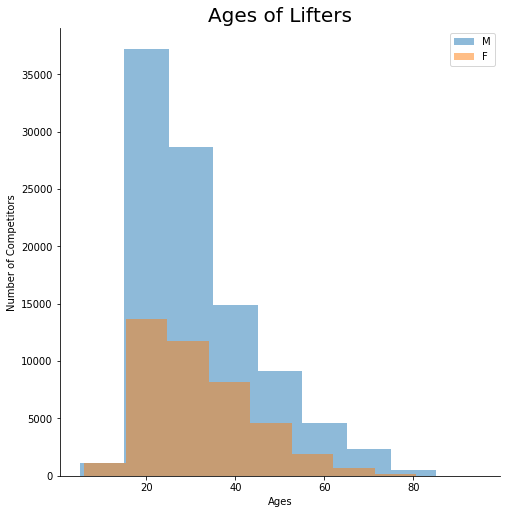

In [16]:
df_with_ages = comps_slim[comps_slim.Age.notnull()]
n_bins = int(np.sqrt(max(df_with_ages.Age) - min(df_with_ages.Age)))
graph = sns.FacetGrid(df_with_ages,hue='Sex', legend_out=True, hue_order=['M', 'F'], height=7)
graph.map(plt.hist,'Age',bins=n_bins,alpha=.5)
plt.title('Ages of Lifters',fontsize=20)
plt.xlabel('Ages')
plt.ylabel('Number of Competitors')
plt.legend(loc=1)
plt.show()

As noted earlier, we observerd the minimum age as 5 years old, and the maximum of 95. Let's take a closer look at lifters under 10, and those above 80. 

In [17]:
df_with_ages[(df_with_ages.Age <= 7) | (df_with_ages.Age >= 90)]

,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks
817,15,Celleste Lindsay,F,Raw,7.0,RY 6-7,32.11,35,20.00,15.50,42.50,78.00,1,127.710
1018,16,Matthew Martinez,M,Raw,5.0,Y5,30.00,30,NaN,NaN,25.00,25.00,1,51.170
1087,19,John Gilmour,M,Raw,95.0,RLM 95-99,90.00,90,NaN,75.00,NaN,75.00,1,47.880
1088,19,John Gilmour,M,Raw,95.0,RM 95-99,90.00,90,NaN,75.00,NaN,75.00,1,47.880
2257,50,Anderson Coleman,M,Raw,7.0,Tested Youth,24.49,39,NaN,NaN,40.82,40.82,1,122.620
114938,4336,Dan Mason,M,Raw,93.0,Open,90.65,93,165.00,107.50,215.00,487.50,2,310.099
162794,5489,Kylie McElhannon,F,Raw,7.0,Youth,15.88,44,NaN,NaN,24.95,24.95,G,37.300
172556,5713,Payton Barabas,M,Raw,7.0,Pre-teen,30.48,44,19.28,12.47,37.51,69.26,2,138.040
172991,5725,William Whitt,M,Raw,6.0,Juniors,71.67,75,NaN,NaN,183.70,183.70,1,135.240
233989,6405,Zachary Jaakkola,M,Raw,7.0,AD M-RT1,27.67,52,NaN,NaN,45.36,45.36,1,107.050


Some columns that have yet to be explore in this dataset are the three best lifts, bodyweight, the total, equipment, and place. 

Next we'll take a look at what equipment is most popular, then we'll start diving into the best lifts. To explore these, we'll need to take into consideration the age, weight, and equipment used by the lifters. 

In [18]:
comps_slim.Equipment.value_counts()

Raw           182225
Single-ply    135290
Wraps          44461
Multi-ply       8526
Straps             7
Name: Equipment, dtype: int64

There are only 7 instances of Straps, which I believe are the same as Wraps. We'll now change any rows affected by this mistake and graph out the distribution. 

Text(0.5, 1.0, 'Equipment Usage')

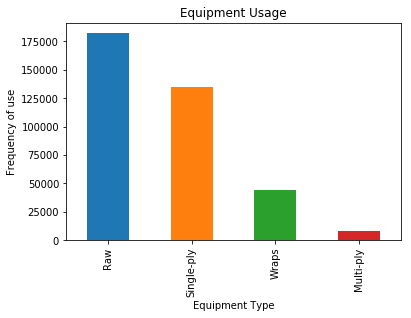

In [19]:
comps_slim.Equipment = comps_slim.Equipment.apply(lambda x: 'Wraps' if x == 'Straps' else x)
comps_slim.Equipment.value_counts().plot(kind='bar')
plt.xlabel('Equipment Type')
plt.ylabel('Frequency of use')
plt.title('Equipment Usage')

We'll now reclassify ages based on USAPL age divisions found on https://en.wikipedia.org/wiki/USA_Powerlifting. Because they don't have a youth category, we'll also create that for lifters under 14 so that they're not included in 'OPEN'. Since there are different age groups for males and females, we'll split the dataframe by Sex then apply 

In [20]:
def age_class_male(x):
    """Classify male lifters into USAPL age group"""
    if x < 14:
        return 'YOUTH'
    elif x < 18:
        return 'SUB-JUNIOR'
    elif x < 23:
        return 'JUNIOR'
    elif (x >= 40) & (x <= 49):
        return 'MASTER I'
    elif (x >= 50) & (x <= 59):
        return 'MASTER II'
    elif (x >= 60) & (x <= 65):
        return 'MASTER III'
    elif (x >= 66) & (x <= 69):
        return 'MASTER IV'
    elif (x >= 70):
        return 'GRANDMASTER'
    else:
        return 'OPEN'
def age_class_female(x):
    """Classify female lifters into USAPL age group"""
    if x < 14:
        return 'YOUTH'
    elif x < 18:
        return 'SUB-JUNIOR'
    elif x < 23:
        return 'JUNIOR'
    elif (x >= 40) & (x <= 49):
        return 'MASTER I'
    elif (x >= 50):
        return 'MASTER II'
    else:
        return 'OPEN'
males_with_ages = males.loc[males.Age.notnull()]
females_with_ages = females.loc[females.Age.notnull()]
males_with_ages['Age'] = males_with_ages.Age.astype(int)
females_with_ages['Age'] = females_with_ages.Age.astype(int)
males_with_ages['AgeGroup'] = males_with_ages.Age.apply(age_class_male)
females_with_ages['AgeGroup'] = females_with_ages.Age.apply(age_class_female)


C:\Users\sarah\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sarah\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sarah\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

Now we'll recombine the males_with_ages and females_with_ages, and put any null values from before back into the dataframe in the group "OPEN". After, we'll create a graph to show distributions of lifters based on age group. 

In [21]:
competitors_with_ages = pd.concat([males_with_ages, females_with_ages])
missing_age = comps_slim[comps_slim.Age.isnull()]
missing_age['AgeGroup'] = 'OPEN'
competitors = pd.concat([competitors_with_ages, missing_age])
competitors.info()

C:\Users\sarah\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'pandas.core.frame.DataFrame'>
Int64Index: 370590 entries, 23 to 386413
Data columns (total 15 columns):
MeetID            370590 non-null int64
Name              370590 non-null object
Sex               370590 non-null category
Equipment         370590 non-null object
Age               140521 non-null float64
Division          355525 non-null object
BodyweightKg      370509 non-null float64
WeightClassKg     370590 non-null object
BestSquatKg       293511 non-null float64
BestBenchKg       350993 non-null float64
BestDeadliftKg    313788 non-null float64
TotalKg           359943 non-null float64
Place             369588 non-null object
Wilks             359864 non-null float64
AgeGroup          370590 non-null object
dtypes: category(1), float64(7), int64(1), object(6)
memory usage: 42.8+ MB


[OPEN, JUNIOR, MASTER I, SUB-JUNIOR, MASTER II, MASTER IV, MASTER III, GRANDMASTER, YOUTH]
Categories (9, object): [OPEN, JUNIOR, MASTER I, SUB-JUNIOR, ..., MASTER IV, MASTER III, GRANDMASTER, YOUTH]
[OPEN, JUNIOR, MASTER I, SUB-JUNIOR, MASTER II, MASTER IV, MASTER III, GRANDMASTER, YOUTH]
Categories (9, object): [OPEN, JUNIOR, MASTER I, SUB-JUNIOR, ..., MASTER IV, MASTER III, GRANDMASTER, YOUTH]


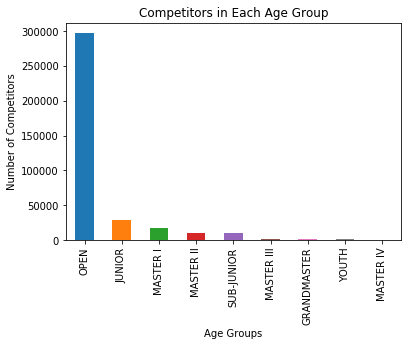

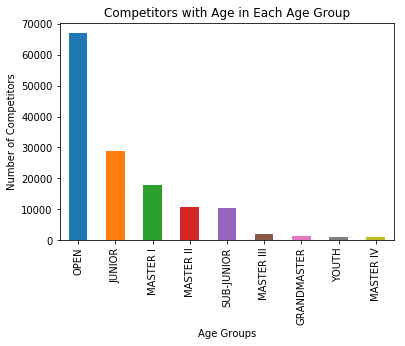

In [22]:
competitors.AgeGroup = competitors.AgeGroup.astype('category')
competitors_with_ages.AgeGroup = competitors_with_ages.AgeGroup.astype('category')
print(competitors.AgeGroup.unique())
print(competitors_with_ages.AgeGroup.unique())

competitors.AgeGroup.value_counts().plot(kind='bar')
plt.title('Competitors in Each Age Group')
plt.xlabel('Age Groups')
plt.ylabel('Number of Competitors')
plt.show()
competitors_with_ages.AgeGroup.value_counts().plot(kind='bar')
plt.title('Competitors with Age in Each Age Group')
plt.xlabel('Age Groups')
plt.ylabel('Number of Competitors')
plt.show()

Looking at these two graphs, the first including all those that were missing ages, the second only those with ages, we see how many people are missing ages. We also can tell that OPEN is the most popular, which means ages 24-39 is the most common for participation. This is expected. 

The next thing we should look at is bodyweight distributions. 


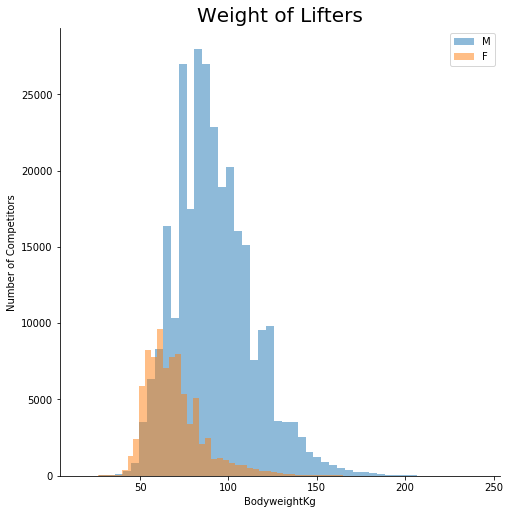

In [23]:
graph = sns.FacetGrid(competitors,hue='Sex', legend_out=True, hue_order=['M', 'F'], height=7)
graph.map(plt.hist,'BodyweightKg',bins=50,alpha=.5)
plt.title('Weight of Lifters',fontsize=20)
plt.ylabel('Number of Competitors')
plt.legend(loc=1)
plt.show()

This histogram shows that male lifters tend to be heavier than female lifters. This makes sense as males tend to be heavier. 

Getting to the fun part, we will next look at the best lifts, and how these values correlate to Age, WeightClass, Sex, and equipment used. 

In [24]:
competitors.head()

,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks,AgeGroup
23,0,Kevin Gingerich,M,Raw,32.0,Open Junior,71.94,75,154.22,115.67,183.70,453.59,2,333.01,OPEN
24,0,Juan Bollo,M,Raw,20.0,Open Junior,70.67,75,163.29,111.13,204.12,478.54,1,356.03,JUNIOR
26,0,James McManus,M,Raw,36.0,Open Junior,74.93,75,NaN,115.67,156.49,272.16,1,194.06,OPEN
27,0,Scott Faircloth,M,Wraps,27.0,Open M/P/F,71.30,75,181.44,99.79,188.24,469.47,1,346.96,OPEN
28,0,Justin Monk,M,Raw,22.0,Open Junior,79.65,82.5,161.03,127.01,197.31,485.35,2,332.27,JUNIOR


C:\Users\sarah\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


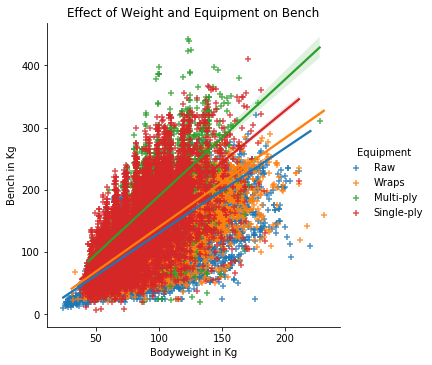

In [25]:
g1 = sns.lmplot(x="BodyweightKg", y="BestBenchKg", hue="Equipment", height=5, truncate=True, data=competitors.dropna(), markers='+')
plt.title('Effect of Weight and Equipment on Bench')
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Bench in Kg')
plt.show()



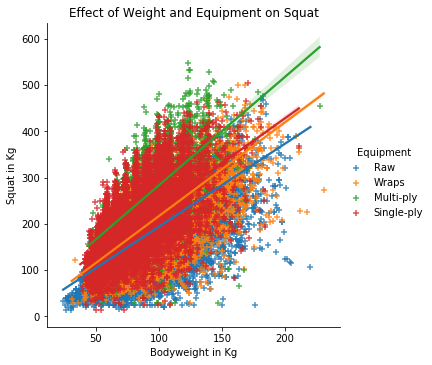

In [26]:
g2 = sns.lmplot(x="BodyweightKg", y="BestSquatKg", hue="Equipment", truncate=True, height=5, data=competitors.dropna(), markers='+')
plt.title('Effect of Weight and Equipment on Squat')
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Squat in Kg')
plt.show()



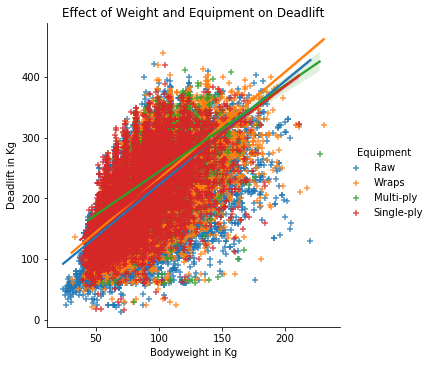

In [27]:
g3 = sns.lmplot(x="BodyweightKg", y="BestDeadliftKg", hue="Equipment", truncate=True, height=5, data=competitors.dropna(), markers='+')
plt.title('Effect of Weight and Equipment on Deadlift')
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Deadlift in Kg')
plt.show()


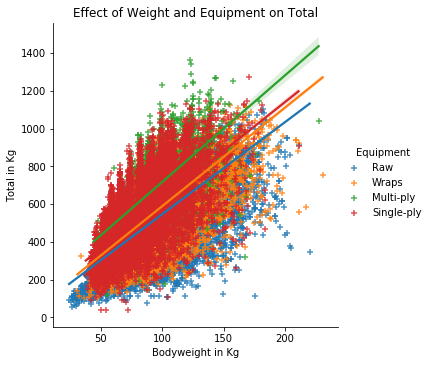

In [28]:
g4 = sns.lmplot(x="BodyweightKg", y="TotalKg", hue="Equipment", truncate=True, height=5, data=competitors.dropna(), markers='+')
plt.title('Effect of Weight and Equipment on Total')
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Total in Kg')
plt.show()

For both Bench and Squat, the graphs look quite similar with Multi-ply dominating all other equipment types, and "raw" doing considerably worse. However, on Deadlifts, the spreadout between equipment doesn't seem to be as far apart, with "Wraps" and "raw" performing better at high bodyweights. 

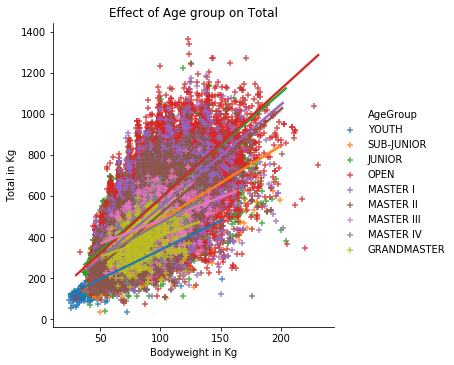

In [29]:
#Age vs lift
g4 = sns.lmplot(x="BodyweightKg", y="TotalKg", hue="AgeGroup", truncate=True, height=5, data=competitors.dropna(), markers='+', hue_order=['YOUTH', 'SUB-JUNIOR', 'JUNIOR', 'OPEN', 'MASTER I', 'MASTER II', 'MASTER III', 'MASTER IV', 'GRANDMASTER'])
plt.title('Effect of Age group on Total')
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Total in Kg')
plt.show()

Looking at this chart, it's a little surprising to see the Junior category is so closely competitive to the open age group. Also, the Master III age group actually competes better than Junior and Open at low bodyweights! 

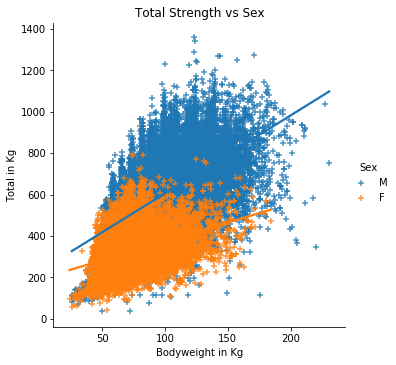

In [30]:
#Sex vs lift
sns.lmplot(x="BodyweightKg", y="TotalKg", hue="Sex", truncate=True, height=5, data=competitors.dropna(), markers='+', hue_order=['M', 'F'])
plt.title('Total Strength vs Sex')
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Total in Kg')
plt.show()

While there are a few females (outliers) that actively life close to the same as males in the same weight classes, overall males lift more. Males tend to gain more strength per added bodyweight than females do. Based off the distributions, it appears that around 125Kg is optimal for male lifters, and about 65Kg for females. 

To explore how the domographic has changed over time, we will be combining our tables so that we can account for the number of males and females over time.

In [31]:
full_comp = pd.merge(meets_df, comps_slim, left_on='MeetID', right_on='MeetID', how='inner')
full_comp.tail()

,MeetID,MeetPath,Federation,Date,MeetCountry,MeetState,MeetTown,MeetName,Month,Year,...,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks
370504,8481,xpc/2017-finals,XPC,2017-03-03,USA,OH,Columbus,2017 XPC Finals,3,2017,...,NaN,Elite,113.58,125,NaN,NaN,347.5,347.5,2,202.60
370505,8481,xpc/2017-finals,XPC,2017-03-03,USA,OH,Columbus,2017 XPC Finals,3,2017,...,NaN,Elite,119.02,125,NaN,NaN,322.5,322.5,3,185.77
370506,8481,xpc/2017-finals,XPC,2017-03-03,USA,OH,Columbus,2017 XPC Finals,3,2017,...,NaN,Elite,120.29,125,NaN,NaN,367.5,367.5,1,211.17
370507,8481,xpc/2017-finals,XPC,2017-03-03,USA,OH,Columbus,2017 XPC Finals,3,2017,...,NaN,Elite,126.73,140,NaN,NaN,320.0,320.0,3,181.85
370508,8481,xpc/2017-finals,XPC,2017-03-03,USA,OH,Columbus,2017 XPC Finals,3,2017,...,NaN,Elite,129.46,140,NaN,NaN,362.5,362.5,2,205.18


In [32]:
comps_slim[(comps_slim.BestBenchKg.isnull()) & (comps_slim.BestSquatKg.isnull()) & (comps_slim.BestDeadliftKg.isnull())]

,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks


In [33]:
full_comp.describe()

,MeetID,Month,Year,Age,BodyweightKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Wilks
count,370509.000000,370509.000000,370509.000000,140440.000000,370509.000000,293469.000000,350917.000000,313739.000000,359864.000000,359864.000000
mean,5107.460685,5.981566,2013.777004,31.604084,86.751971,177.464549,119.348474,195.574497,423.639249,300.891253
std,2565.603223,3.668868,5.361963,12.903788,23.047233,65.318732,51.035142,58.983585,195.537048,116.159855
min,0.000000,1.000000,1974.000000,5.000000,15.880000,13.600000,6.800000,2.270000,11.000000,13.730000
25%,2854.000000,3.000000,2014.000000,22.000000,70.100000,127.500000,79.380000,147.500000,272.500000,237.330000
50%,5935.000000,6.000000,2016.000000,28.000000,83.000000,174.630000,115.670000,195.000000,424.110000,319.610000
75%,7154.000000,9.000000,2017.000000,39.000000,100.000000,217.720000,150.000000,238.140000,565.000000,379.160000
max,8481.000000,12.000000,2018.000000,95.000000,242.400000,573.790000,488.500000,460.400000,1365.310000,779.380000


In [34]:
max(full_comp.Date)

Timestamp('2018-01-28 00:00:00')

<Figure size 720x504 with 0 Axes>

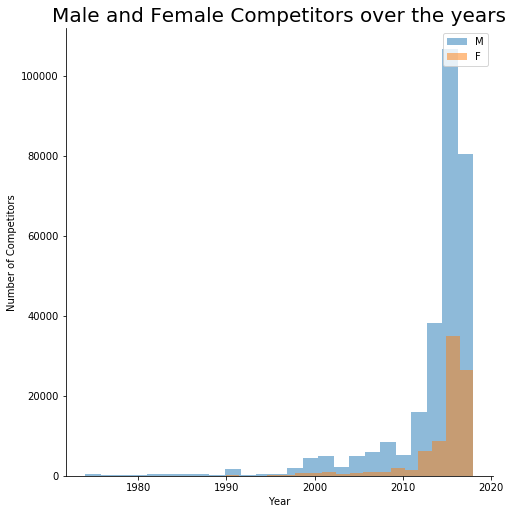

In [35]:
plt.figure(figsize=(10,7))
_ = sns.FacetGrid(full_comp,hue='Sex', legend_out=True, hue_order=['M', 'F'], height=7)
_.map(plt.hist,'Year',bins=25,alpha=.5)
plt.title('Male and Female Competitors over the years',fontsize=20)
plt.ylabel('Number of Competitors')
plt.legend(loc=1)
plt.show()

Something else that will be interesting to see from the joined tables is what the max values from the Wilks score column is each year. This column will be used later for some exploratory data analysis.

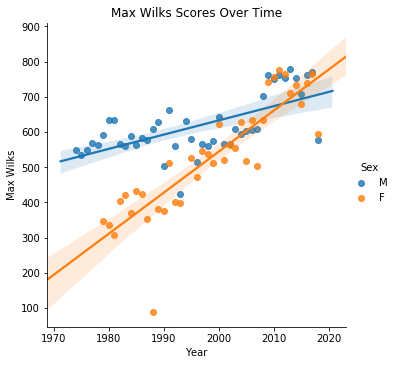

In [36]:
fem_full_comp = full_comp[full_comp.Sex == 'F']
mal_full_comp = full_comp[full_comp.Sex == 'M']

fem_full_comp_max = fem_full_comp.groupby('Year')['Wilks'].max().to_frame().reset_index()
fem_full_comp_max['Sex'] = 'F'
mal_full_comp_max = mal_full_comp.groupby('Year')['Wilks'].max().to_frame().reset_index()
mal_full_comp_max['Sex'] = 'M'
full_comp_max = pd.concat([fem_full_comp_max, mal_full_comp_max])

sns.lmplot(x='Year', y='Wilks', data=full_comp_max, hue='Sex', hue_order=['M', 'F'])
plt.title('Max Wilks Scores Over Time')
plt.xlabel('Year')
plt.ylabel('Max Wilks')
plt.show()

Looking at these linear regressions, females are progressing in the Wilks scores at a higher rate than males.

## EDA on Wilks Score

One column that has yet to be explored is the Wilks Score. This value is a computed with a formula to normalize lifts across weight classes. The constant values on the bottom differ between Males and Females, to help bridge a gap between them. 
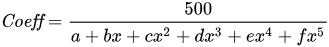


In [37]:
females.Wilks.describe()

count    83428.000000
mean       286.712437
std        108.454925
min         18.946200
25%        234.430000
50%        299.170000
75%        353.720000
max        776.170000
Name: Wilks, dtype: float64

In [38]:
males.Wilks.describe()

count    276436.000000
mean        305.170401
std         118.052857
min          13.730000
25%         238.890000
50%         327.070000
75%         385.898500
max         779.380000
Name: Wilks, dtype: float64

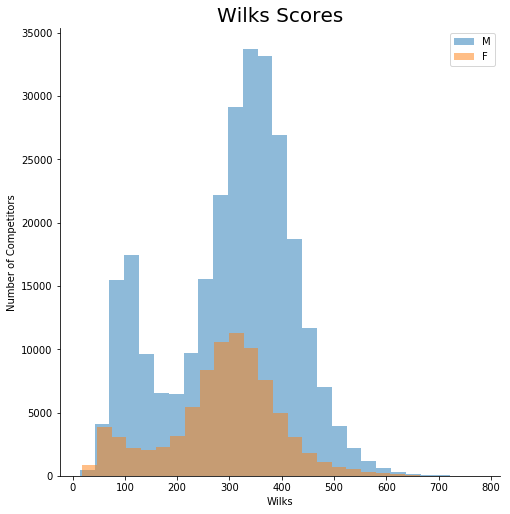

In [39]:
n_bins = int(np.sqrt(max(competitors.Wilks) - min(competitors.Wilks)))
graph = sns.FacetGrid(competitors,hue='Sex', legend_out=True, hue_order=['M', 'F'], height=7)
graph.map(plt.hist,'Wilks',bins=n_bins,alpha=.5)
plt.title('Wilks Scores',fontsize=20)
plt.ylabel('Number of Competitors')
plt.legend(loc=1)
plt.show()

Looking at this, we see two peaks in the graph. This is due to people only competing in a single lift, rather than total. For comparing these, we will look only at lifters who competed in all three lifts.

In [40]:
all_lifts = competitors[(competitors.BestBenchKg.notna()) & (competitors.BestSquatKg.notna()) & (competitors.BestDeadliftKg.notna())]
all_lifts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284341 entries, 23 to 386383
Data columns (total 15 columns):
MeetID            284341 non-null int64
Name              284341 non-null object
Sex               284341 non-null category
Equipment         284341 non-null object
Age               105372 non-null float64
Division          270965 non-null object
BodyweightKg      284301 non-null float64
WeightClassKg     284341 non-null object
BestSquatKg       284341 non-null float64
BestBenchKg       284341 non-null float64
BestDeadliftKg    284341 non-null float64
TotalKg           283895 non-null float64
Place             283645 non-null object
Wilks             283855 non-null float64
AgeGroup          284341 non-null category
dtypes: category(2), float64(7), int64(1), object(5)
memory usage: 30.9+ MB


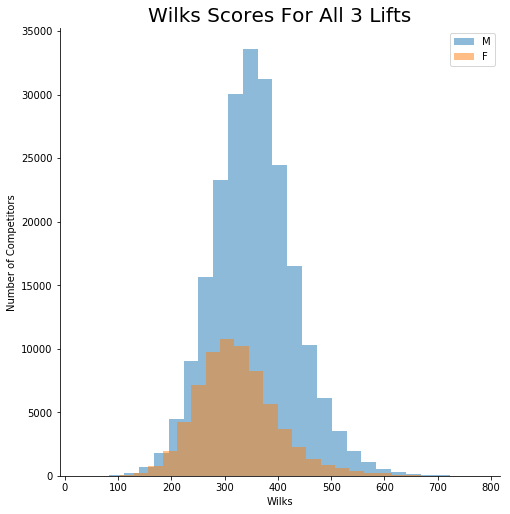

In [41]:
n_bins = int(np.sqrt(max(all_lifts.Wilks) - min(all_lifts.Wilks)))
graph = sns.FacetGrid(all_lifts,hue='Sex', legend_out=True, hue_order=['M', 'F'], height=7)
graph.map(plt.hist,'Wilks',bins=n_bins,alpha=.5)
plt.title('Wilks Scores For All 3 Lifts',fontsize=20)
plt.ylabel('Number of Competitors')
plt.legend(loc=1)
plt.show()

Looking at these normalized values, we see females have an average Wilks score of 286, and males have an average Wilks score of 305. We'll be exploring these farther. 

Our hypothesis is that after total weights have been normalized for bodyweight, the average male's Wilks score is equal to the average female's Wilks score.
* H0: mean(females.Wilks) = mean(males.Wilks)
* H1: mean(females.Wilks) ≠ mean(males.Wilks)

In [42]:
# Function that will be used in computing the ECDF 
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x: sort the data
    x = np.sort(data)

    # y: range for y-axis
    y = np.arange(1, n+1) / n

    return x, y
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

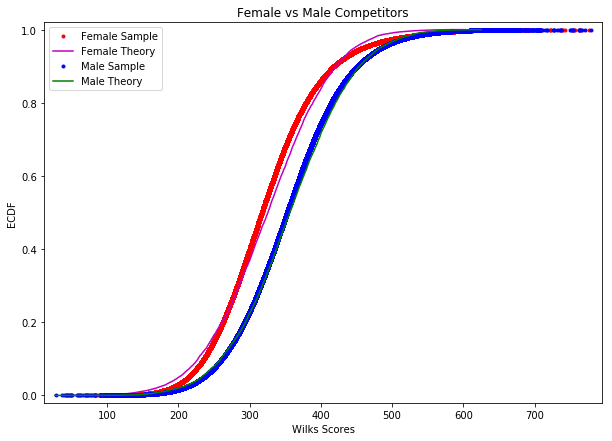

In [43]:
fem_all_lifts = all_lifts[all_lifts.Sex == 'F']
mal_all_lifts = all_lifts[all_lifts.Sex == 'M']
fem_all_lifts = fem_all_lifts[fem_all_lifts.Wilks.notna()]
mal_all_lifts = mal_all_lifts[mal_all_lifts.Wilks.notna()]

fem_mean = np.mean(fem_all_lifts.Wilks)
fem_std = np.std(fem_all_lifts.Wilks)
mal_mean = np.mean(mal_all_lifts.Wilks)
mal_std = np.std(mal_all_lifts.Wilks)

fem_theory = np.random.normal(fem_mean, fem_std, 10000)
mal_theory = np.random.normal(mal_mean, mal_std, 10000)


fem_x, fem_y = ecdf(fem_all_lifts.Wilks)
f_theory_x, f_theory_y = ecdf(fem_theory)

mal_x, mal_y = ecdf(mal_all_lifts.Wilks)
m_theory_x, m_theory_y = ecdf(mal_theory)

plt.figure(figsize=(10,7))
_ = plt.plot(fem_x, fem_y, marker='.', linestyle='none', color='r')
_ = plt.plot(f_theory_x, f_theory_y, color='m')
_ = plt.plot(mal_x, mal_y, marker='.', linestyle='none', color='b')
_ = plt.plot(m_theory_x, m_theory_y, color='g')
_ = plt.xlabel('Wilks Scores')
_ = plt.ylabel('ECDF')
_ = plt.title('Female vs Male Competitors')
_ = plt.legend(('Female Sample',  'Female Theory', 'Male Sample', 'Male Theory'))
plt.margins(0.02)
plt.show()

Both Groups look approximately normal, with slight variations in where their mean lies. 

In [44]:
# We need to translate our female's average Wilks score so that it matches the males
# We then need to take samples of this translated set to find the percent of the time we would observe our sample's mean
# if the true mean is equal between male and female lifters
fem_translated = fem_all_lifts.Wilks - fem_mean + mal_mean
bs_samples = draw_bs_reps(fem_translated, np.mean, 10000)
p = np.sum(bs_samples <= fem_mean) / 10000
print('p = ', p)
print(fem_mean)

p =  0.0
323.90315800264324


In [45]:
np.mean(bs_samples)

355.172872447442

In [46]:

fem_var = np.var(fem_all_lifts.Wilks)
mal_var = np.var(mal_all_lifts.Wilks)
print('Female variance: ', fem_var)
print('Male variance: ', mal_var)

Female variance:  5732.074443632786
Male variance:  5756.409868097271


In [47]:
# We will use ttest_ind from scipy.stats, as the average Wilks scores should be equal, per the hypothesis
# The parameter equal_var needs to be set to false, as computed above, the groups do not have equal variances
t_stat, p_val = st.ttest_ind(mal_all_lifts.Wilks, fem_all_lifts.Wilks, equal_var = False)
print("The T-statistic for this data is: ", t_stat)
print("with a p-value of: ", p_val)

The T-statistic for this data is:  94.22249954494329
with a p-value of:  0.0


In the first test, we shifted the mean of our female competitors' Wilks scores so that the mean matched that of the male Wilks scores. After doing so, we created boostrap replicates, and computed the mean for these groups, and looked to see how many of our 10,000 replicates got a mean that was less than or equal to the mean of our data. The p-value we obtained from this was 0.0, so none of the 10,000 replicates were able to get a mean as extreme as our data's. 

Our computations have resulted in a T-Statistic of 94.2, and a p-value of 0. This means that to obtain a scenario of the data we have above, if the mean Wilks score was equal for males and females, we would have to be 94 standard deviations away, and our p-value is so low, even built in statistical methods couldn't obtain a value. 

From this, we can conclude that we should reject the null hypothesis, and offer up our H1 hypothesis that there is a difference in Wilks scores for males and females, even with altered constants used in computing them. Were males and females ever to compute against each other, this Wilks score formula would need to be adjusted to account for the difference in male and female strength. In fact, some powerlifting competitions have started switching away from using the wilks score, and are normalizing lifts differently. 

There is still a large gap in the number of male and female lifters, and in the future, this gap in the wilks score could close on its own, as more females begin competing, and more research is done of female strength, but for now it is safe to say male competitors are stronger overall. 

In [48]:
competitors[competitors.Wilks == max(fem_all_lifts.Wilks)]

,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks,AgeGroup
162483,5479,Laura Phelps-Sweatt,F,Multi-ply,NaN,Pro,75.0,75,337.93,240.4,238.14,816.47,1,776.17,OPEN


In [49]:
competitors[competitors.Wilks == max(mal_all_lifts.Wilks)]

,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks,AgeGroup
53198,1329,Dave Hoff,M,Multi-ply,25.0,Heavyweight,122.97,125,548.85,442.25,371.95,1363.05,1,779.38,OPEN


# Machine Learning
The first thing we're going to do is trim down the original full table to just the columns that will be useful, as well as adding in some new columns to help with predictions. 

In [120]:
pd.options.display.max_columns = None
full_comp_trim = full_comp.drop(['MeetPath', 'Federation', 'MeetCountry', 'MeetState', 'MeetTown', 'MeetName', 'Month', 'Division', 'Place'], axis=1)
full_comp_trim.sort_values('Date', inplace=True)
full_comp_trim = full_comp_trim.drop_duplicates(subset=['Date', 'Name', 'Sex'], keep='first')


In [121]:
full_comp_trim.sort_values(['Name', 'Sex', 'Date'], inplace=True)
full_comp_trim['Num_meets'] = full_comp_trim.groupby(['Name', 'Sex']).cumcount() + 1
full_comp_trim.head()

,MeetID,Date,Year,Name,Sex,Equipment,Age,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Wilks,Num_meets
44252,1233,2014-08-16,2014,A Blank,M,Raw,NaN,90.90,93,185.00,115.00,230.00,530.00,336.66,1
190864,6005,2016-02-20,2016,A Brown,M,Single-ply,NaN,101.15,110,208.65,111.13,215.46,535.24,324.28,1
17259,363,1999-01-30,1999,A Bury,M,Single-ply,NaN,67.50,67.5,135.00,85.00,160.00,380.00,292.99,1
44336,1234,2015-08-14,2015,A Dawes,M,Raw,NaN,63.00,66,187.50,127.50,202.50,517.50,422.61,1
44267,1233,2014-08-16,2014,A Freemantle,M,Raw,NaN,98.70,105,217.50,132.50,250.00,600.00,367.10,1


In [122]:
full_comp_trim.sort_values('Num_meets', ascending=False).head()
full_comp_trim[full_comp_trim.Name == 'Stefanie Cohen']['BodyweightKg']

151407    56.00
367537    55.61
152262    55.34
351898    52.00
368628    55.20
153908    55.61
Name: BodyweightKg, dtype: float64

Next we want to create a column to indicate whether the lifter participated in bench only, squat only, deadlift only, or any 2 or more of the lifts. 

We will make it a numeric column with 
* 0 for bench only
* 1 for squat only
* 2 for deadift only
* 3 for 2 or more lifts

In [123]:
full_comp_trim.loc[(pd.notna(full_comp_trim.BestBenchKg)) 
                & (full_comp_trim.BestSquatKg.isnull()) 
                & (full_comp_trim.BestDeadliftKg.isnull()), 'lift_types'] = "Bench"
full_comp_trim.loc[(full_comp_trim.BestBenchKg.isnull()) 
                & (pd.notna(full_comp_trim.BestSquatKg)) 
                & (full_comp_trim.BestDeadliftKg.isnull()), 'lift_types'] = "Squat"
full_comp_trim.loc[(full_comp_trim.BestBenchKg.isnull()) 
                & (full_comp_trim.BestSquatKg.isnull()) 
                & (pd.notna(full_comp_trim.BestDeadliftKg)), 'lift_types'] = "Deadlift"
full_comp_trim.loc[full_comp_trim.lift_types.isnull(), 'lift_types'] = "Multiple"
full_comp_trim.lift_types = full_comp_trim.lift_types.astype('category')
full_comp_trim.info()
full_comp_trim = full_comp_trim[(full_comp_trim.Wilks.notnull())]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336965 entries, 44252 to 49637
Data columns (total 16 columns):
MeetID            336965 non-null int64
Date              336965 non-null datetime64[ns]
Year              336965 non-null int64
Name              336965 non-null object
Sex               336965 non-null category
Equipment         336965 non-null object
Age               120784 non-null float64
BodyweightKg      336965 non-null float64
WeightClassKg     336965 non-null object
BestSquatKg       274278 non-null float64
BestBenchKg       321738 non-null float64
BestDeadliftKg    288691 non-null float64
TotalKg           326844 non-null float64
Wilks             326844 non-null float64
Num_meets         336965 non-null int64
lift_types        336965 non-null category
dtypes: category(2), datetime64[ns](1), float64(7), int64(3), object(3)
memory usage: 39.2+ MB


Wouldn't it be neat to be able to predict how well someone will do based on only the info they give going into the meet? That's what we'll try to do. We'll start out with linear regression to predict a wilks value, leaving out the BestSquatKg, BestBenchKg, and BestDeadliftKg. Since the Wilk's score is based off of them, and those values aren't known prior to entering a competition, they wouldn't make for a great model. The Equipment column will be split so that it can be used as numerical data instead. 

In [143]:
from sklearn.preprocessing import StandardScaler , PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import sklearn.utils
import warnings
warnings.filterwarnings("ignore")



In [144]:
index = ['LinearRegression','Lasso','Ridge','RandomForestRegressor','KNeighborsRegressor']
score_table = pd.DataFrame(index = index, columns= ['r2_train','r2_test','mse_train','mse_test'])

In [145]:
equip = pd.get_dummies(full_comp_trim['Equipment'], drop_first=True)
sex = pd.get_dummies(full_comp_trim['Sex'], drop_first=True)
lifts = pd.get_dummies(full_comp_trim['lift_types'])
ml_df = pd.concat([full_comp_trim, equip, sex, lifts], axis = 1)
ml_df.sort_values(['Name', 'Sex', 'Date'], inplace=True)


In [146]:
# Drop text columns as well as the categorical columns that have been transformed
# aq
r_idx = np.random.permutation(len(ml_df))
ml_df = ml_df.drop(['MeetID','Age', 'Date', 'Sex', 'Equipment', 'Name', 'WeightClassKg', 'BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg', 'lift_types'], axis=1)
ml_df = sklearn.utils.shuffle(ml_df)
ml_df = ml_df.reset_index(drop=True)
X = ml_df.drop(['Wilks'], axis=1)
y = ml_df['Wilks']
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

(326844, 11) (326844,)


In [147]:
def multi_scores(model, train_pred, test_pred):
    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    mse_train = mean_squared_error(y_train, train_pred)
    mse_test = mean_squared_error(y_test, test_pred)
    score_table.loc[model,:] = r2_train, r2_test, mse_train, mse_test

In [148]:
#Linear Regression
linreg = Pipeline(steps = [('scaler', StandardScaler()), ('linreg', LinearRegression())])
linreg.fit(X_train, y_train)
train_pred = linreg.predict(X_train)
test_pred = linreg.predict(X_test)
features = pd.DataFrame({'Feature':X_train.columns, 'Coefficient':linreg.named_steps.linreg.coef_})
print(features.sort_values('Coefficient', ascending=False))
multi_scores('LinearRegression', train_pred, test_pred)


         Feature   Coefficient
2      Num_meets  1.116582e+01
6              M  8.664793e+00
1   BodyweightKg  6.457718e+00
0           Year -8.475698e+00
5          Wraps -2.175606e+01
4     Single-ply -4.952720e+01
3            Raw -4.983460e+01
10         Squat -3.189559e+12
8       Deadlift -1.250666e+13
7          Bench -2.497407e+13
9       Multiple -2.732594e+13


In [160]:
#LASSO 

lasso = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso())])

parms = {'lasso__alpha': np.arange(0.05, 1, 0.05)}
lasso_cv = GridSearchCV(lasso, parms, scoring = 'r2')
lasso_cv.fit(X_train, y_train)

best_parm = lasso_cv.best_params_
print(best_parm['lasso__alpha'], lasso_cv.best_score_)

lasso = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha = best_parm['lasso__alpha']))])
lasso.fit(X_train, y_train)
train_pred = lasso.predict(X_train)
test_pred = lasso.predict(X_test)

features = pd.DataFrame({'Feature':X_train.columns, 'Coefficient':lasso.named_steps.lasso.coef_})
print(features.sort_values('Coefficient', ascending=False))

multi_scores('Lasso', train_pred, test_pred)

0.05 0.6166399136926933
         Feature  Coefficient
9       Multiple    26.657512
2      Num_meets    11.104002
6              M     8.623133
1   BodyweightKg     6.461629
10         Squat    -6.371621
0           Year    -8.336732
8       Deadlift   -20.103531
5          Wraps   -20.761867
4     Single-ply   -48.052221
3            Raw   -48.364493
7          Bench   -59.883573


In [163]:
#Ridge
ridge = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])

parms = {'ridge__alpha': np.arange(0.05, 5, 0.05)}
ridge_cv = GridSearchCV(ridge, parms, scoring = 'r2')
ridge_cv.fit(X_train, y_train)

best_parm = ridge_cv.best_params_
print(best_parm['ridge__alpha'], ridge_cv.best_score_)

ridge = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha = best_parm['ridge__alpha']))])
ridge.fit(X_train, y_train)
train_pred = ridge.predict(X_train)
test_pred = ridge.predict(X_test)

features = pd.DataFrame({'Feature':X_train.columns, 'Coefficient':ridge.named_steps.ridge.coef_})
print(features.sort_values('Coefficient', ascending=False))

multi_scores('Ridge', train_pred, test_pred)

2.1 0.6166564992773895
         Feature  Coefficient
9       Multiple    45.180938
2      Num_meets    11.171296
6              M     8.663094
1   BodyweightKg     6.458908
10         Squat    -4.268449
0           Year    -8.406626
8       Deadlift   -11.689288
5          Wraps   -21.772716
7          Bench   -43.036780
4     Single-ply   -49.548290
3            Raw   -49.851809


In [167]:
#KNeighbors 

knn = Pipeline([('scaler', StandardScaler()),('knn',KNeighborsRegressor())])

parameters = {'knn__n_neighbors': np.arange(70,120,10),'knn__weights':['distance','uniform']}
knn_cv = GridSearchCV(knn, parameters, scoring='r2')
knn_cv.fit(X_train, y_train)
print(knn_cv.best_params_)
print(knn_cv.best_score_)

best_n = knn_cv.best_params_['knn__n_neighbors']
best_weights = knn_cv.best_params_['knn__weights']

knn = Pipeline([('scaler', StandardScaler()),('knn',KNeighborsRegressor(n_neighbors=best_n, weights=best_weights))])
knn.fit(X_train, y_train)
train_pred = knn.predict(X_train)
test_pred = knn.predict(X_test)

multi_scores('KNeighborsRegressor', train_pred, test_pred)

{'knn__n_neighbors': 70, 'knn__weights': 'uniform'}
0.6853885068332503


In [166]:
#Random Forest

random_forest = Pipeline([('scaler', StandardScaler()),('random_forest',RandomForestRegressor())])

parameters = {'random_forest__n_estimators': np.arange(150,200,10), 'random_forest__max_features':['auto','sqrt','log2']}
random_forest_cv = GridSearchCV(random_forest, parameters, scoring='r2')
random_forest_cv.fit(X_train, y_train)
print(random_forest_cv.best_params_)
print(random_forest_cv.best_score_)
best_est = random_forest_cv.best_params_['random_forest__n_estimators']
best_feat = random_forest_cv.best_params_['random_forest__max_features']

random_forest = Pipeline([('scaler', StandardScaler()),('random_forest', RandomForestRegressor(n_estimators=best_est, max_features=best_feat, n_jobs=2))])
random_forest.fit(X_train, y_train)
train_pred = random_forest.predict(X_train)
test_pred = random_forest.predict(X_test)

features = pd.DataFrame({'Feature':X_train.columns, 'Importance':random_forest.named_steps.random_forest.feature_importances_})
print(features.sort_values('Importance', ascending=False))

multi_scores('RandomForestRegressor', train_pred, test_pred)

{'random_forest__max_features': 'auto', 'random_forest__n_estimators': 190}
0.6288748947123397
         Feature  Importance
9       Multiple    0.605575
1   BodyweightKg    0.207823
2      Num_meets    0.062507
0           Year    0.057439
4     Single-ply    0.017526
3            Raw    0.016890
6              M    0.015733
5          Wraps    0.012102
7          Bench    0.004332
8       Deadlift    0.000039
10         Squat    0.000035


In [168]:
score_table

,r2_train,r2_test,mse_train,mse_test
LinearRegression,0.616686,0.613572,4947.13,4962.3
Lasso,0.61667,0.613555,4947.35,4962.51
Ridge,0.616687,0.613567,4947.13,4962.36
RandomForestRegressor,0.874036,0.628828,1625.72,4766.39
KNeighborsRegressor,0.696588,0.685299,3915.91,4041.22


## Summary:
We achieved our best R-squared score from the KNeighbors model, and it was paired with the lowest mean squared error. From every model, we saw that the biggest factor in predicting the Wilks score was the "Multiplie" column that indicated whether a person participated in 2 or more lifts. 

While it may have improved the model to further separate it out to competing in the 3 combinations of lift pairs, and competing in all three, this wouldn't make sense with the data. In powerlifting competitions, you can select to do a single lift, or all three; the only way to do two lifts is to completely miss one of your lifts for all three attempts. 

In all but the random forests, knowing the number of meets someone had competed in was the second best indicator in how they would do. While we saw through our EDA that males and females do have different averages, knowing someone's sex didn't help much in predicting how they would do. 

Our random forest model showed that the bodyweight of the participant was a large factor in making predictions. 